In [1]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras

Using TensorFlow backend.


In [2]:
class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name
    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))
    # !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

d:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


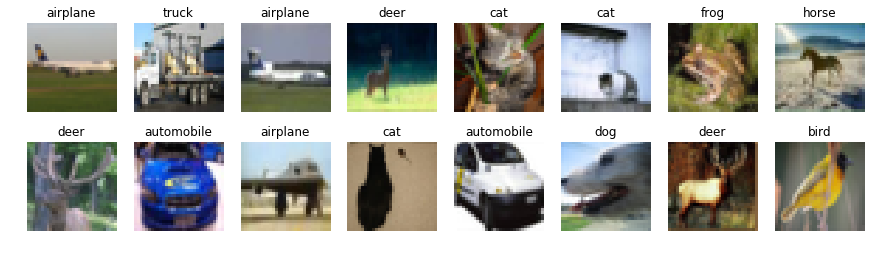

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
 "dog", "frog", "horse", "ship", "truck"]
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [5]:
IMG_SHAPE = x_train.shape[1:]
# center images
x_train = x_train.astype('float32') / 255.0 - 0.5
x_test = x_test.astype('float32') / 255.0 - 0.5
print(IMG_SHAPE)

(32, 32, 3)


In [6]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
 
 # encoder
    encoder = keras.models.Sequential()
#     encoder.add(L.InputLayer(img_shape))
 
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same',input_shape = img_shape) )
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten()) #flatten image to vector
    encoder.add(L.Dense(code_size)) 
# encoder.summary()
 # decoder
    decoder = keras.models.Sequential()
#     decoder.add(L.InputLayer((code_size,)))
 
    decoder.add(L.Dense(2*2*256,input_dim = code_size)) #actual decoder, height*width*3 units
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
 
    return encoder, decoder

In [7]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)         295168    
__________

In [14]:
# inp = L.Input(IMG_SHAPE)
# code = encoder(inp)
# reconstruction = decoder(code)
# autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
# autoencoder.compile(optimizer="adamax", loss='mse')
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = 4
# ### uncomment below to continue training from model checkpoint
# ### fill `last_finished_epoch` with your latest finished epoch
from keras.models import load_model
# s = reset_tf_session()
last_finished_epoch = 4
autoencoder = load_model(model_filename.format(last_finished_epoch))

encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]
autoencoder.fit(x=x_train, y=x_train,
                epochs=10,validation_data=[x_test, x_test],
                callbacks=[ModelSaveCallback(model_filename)],
                verbose=1,
                initial_epoch=last_finished_epoch or 0)

Train on 50000 samples, validate on 10000 samples
Epoch 5/10
50000/50000 [==============================] - 448s - loss: 0.0239 - val_loss: 0.0155
Epoch 6/10
50000/50000 [==============================] - 445s - loss: 0.0140 - val_loss: 0.0131
Epoch 7/10
50000/50000 [==============================] - 468s - loss: 0.0129 - val_loss: 0.0127
Epoch 8/10
50000/50000 [==============================] - 443s - loss: 0.0125 - val_loss: 0.0124
Epoch 9/10
50000/50000 [==============================] - 436s - loss: 0.0122 - val_loss: 0.0122
Epoch 10/10
50000/50000 [==============================] - 435s - loss: 0.0120 - val_loss: 0.0120


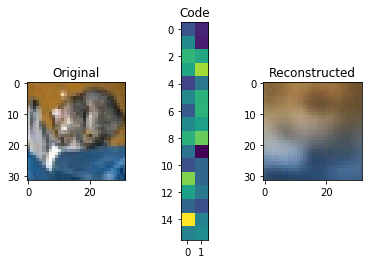

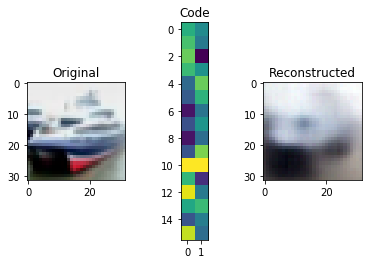

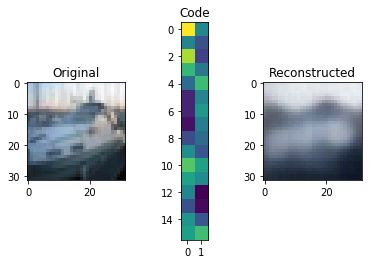

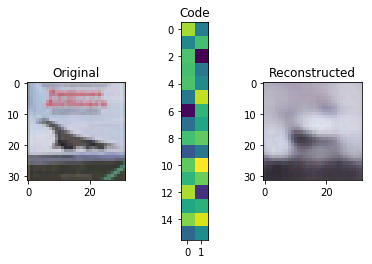

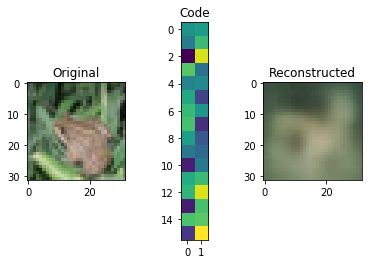

In [27]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0] # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]
    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)
    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))
    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
#     plt.imshow(x)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0 - 0.5
x_test = x_test.astype('float32') / 255.0 - 0.5
# reconstruction_mse = autoencoder.evaluate(x_test, x_test, verbose=1)
# print("Convolutional autoencoder MSE:", reconstruction_mse)

for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)
# plt.imshow(x_test[0])

In [28]:
images = x_train
codes = encoder.predict(images)
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    code = encoder.predict(image[None])
 
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
 
    return distances,images[idx]
def show_similar(image):
 
    distances,neighbors = get_similar(image,n_neighbors=3)
 
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
 
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

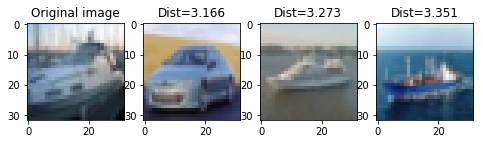

In [30]:
show_similar(x_test[2])

In [34]:
codes[0].shape

(32,)